# Consensus motif search
Matrix profiles (MP) can be used to find conserved structure within a single time series (self-join) and across two time series (AB-join). When considering sets of more than two time series one trick is to concatenate all time series (individual series edge-marked by `np.nan`) and doing a self-join MP. However, this is not guaranteed to find patterns that are conserved across *all* time series in the set. This idea of a motif common to all time series in a set is called **consensus motif**.
In this tutorial we will use the so called *Ostinato* algorithm which is an efficient way to find the consensus motif.

## Getting started
Some boilerplate code for getting data, mathematical operations and plotting.

In [1]:
%matplotlib inline

import stumpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import cycle, combinations
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.special import comb

In [2]:
# Set figures to 20 by 6 inches
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['xtick.direction'] = 'out'

# Japanese characters in first example
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Noto Sans CJK JP:black'
plt.rcParams['mathtext.cal'] = 'Noto Sans CJK JP:normal'

## Eye-tracking (EOG) data
In the following data set a volunteer spelled out different Japanese sentences by performing eye movements that represented individual characters. Eye movements were recorded by an electrooculograph. For our purposes we're just using the vertical positions. We're conceptually reproducing figures 1 and 2 of the [consensus motif paper](https://www.cs.ucr.edu/~eamonn/consensus_Motif_ICDM_Long_version.pdf).

### Retrieve the data

In [3]:
snt_oi = [6, 7, 9, 10, 16, 24]
eye = [None] * len(snt_oi)
fs = 50 # eog signal was downsampled to 50 Hz
 
for i, s in enumerate(snt_oi):
    eye[i] = pd.read_csv(f'https://zenodo.org/record/4288978/files/EOG_001_01_{s:03d}.csv?download=1').iloc[:, 0].values
        
# the literal sentences
sentences = pd.read_csv(f'https://zenodo.org/record/4288978/files/test_sent.jp.csv?download=1', index_col=0)

### Plot the data

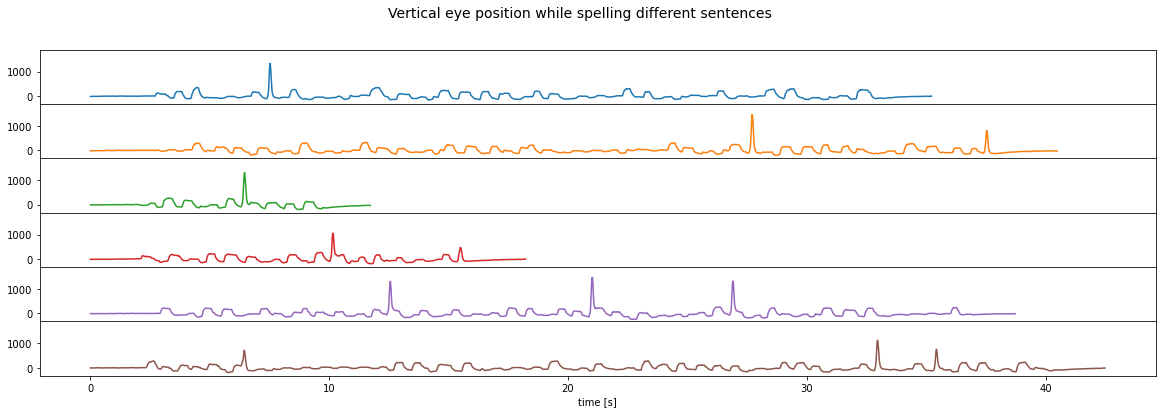

In [4]:
def plot_vertical_eog():    
    fig, ax = plt.subplots(6, sharex=True, sharey=True)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = cycle(prop_cycle.by_key()['color'])
    for i, e in enumerate(eye):
        ax[i].plot(np.arange(0, len(e)) / fs, e, color=next(colors))
        ax[i].set_ylim((-330, 1900))
    plt.subplots_adjust(hspace=0)
    plt.xlabel('time [s]')
    return ax

plot_vertical_eog()
plt.suptitle('Vertical eye position while spelling different sentences', fontsize=14)
plt.show()

Above we plotted six time series that each represent the vertical eye position while a person spelled sentences using their eyes.

### Consensus motif search
What is the 1 second long pattern that is common across these six time series? To find out, we use `stumpy.ostinato`.

In [5]:
m = fs
rad, tsidx, ssidx = stumpy.ostinato(eye, m)
print(f'Found best radius {np.round(rad, 2)} in time series {tsidx} starting at index location {ssidx}.')

Found best radius 0.87 in time series 4 starting at index location 1271.


Let's plot the corresponding matches in the individual time series.

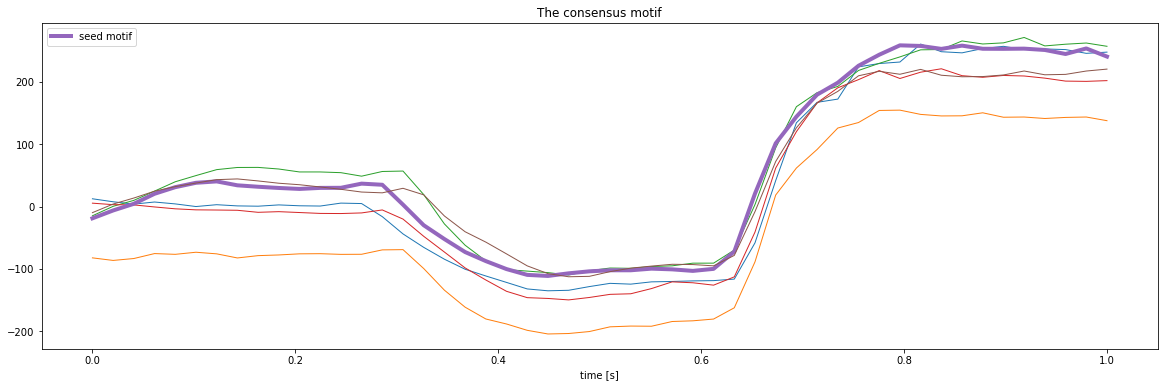

In [6]:
seed_motif = eye[tsidx][ssidx:ssidx+m]
x = np.linspace(0,1,50)
nn = np.zeros(len(eye), dtype=int)
nn[tsidx] = ssidx
for i, e in enumerate(eye):
    if i != tsidx:
        nn[i] = np.argmin(stumpy.core.mass(seed_motif, e))
        lw = 1
        label = None
    else:
        lw = 4
        label = 'seed motif'
    plt.plot(x, e[nn[i]:nn[i]+m], lw=lw, label=label)
plt.title('The consensus motif')
plt.xlabel('time [s]')
plt.legend()
plt.show()

There is a striking similarity between the subsequences. The most central seed motif is plotted with a thicker line.

Highlighting the motifs in context we see that they occur at different times. The discovered pattern corresponds to the Japanese character ア which occurs at different positions of the example sentences (see the sentences in the top left corners of the subplots).

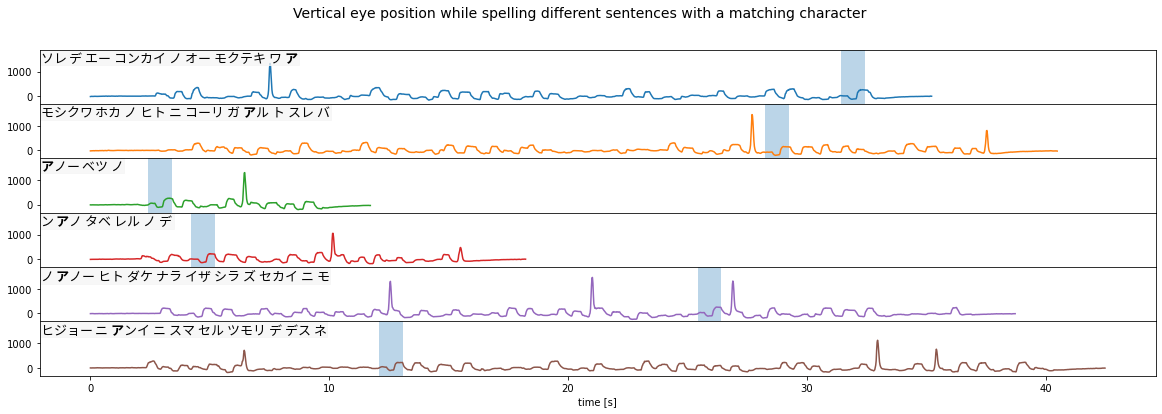

In [7]:
ax = plot_vertical_eog()
sentences_example = sentences.loc[snt_oi].values
for i in range(len(eye)):
    y = ax[i].get_ylim()
    r = Rectangle((nn[i] / fs, y[0]), 1, y[1]-y[0], alpha=0.3)
    ax[i].add_patch(r)
    this_sentence = sentences_example[i]
    ax[i].text(-2.1,
               1900, 
               this_sentence[0].replace('ア', '$\\bf{ア}$'),
               fontname = 'Noto Sans CJK JP',
               ha='left',
               va='top',
               fontsize=13, 
               bbox={'color': 'whitesmoke', 'alpha': 0.8, 'pad': 0},
               zorder=2)
plt.suptitle('Vertical eye position while spelling different sentences with a matching character', fontsize=14)
plt.show()

## Phylogeny using mitochondrial DNA (mtDNA)

[Mitochondrial DNA (mtDNA)](https://en.wikipedia.org/wiki/Mitochondrial_DNA) has been successfully used to figure out evolutionary relationships of organisms (phylogeny). Since DNAs are essentially ordered sequences of letters we can treat them as time series and use all the available time series tools. Here we will reproduce figure 9 of [consensus motif paper](https://www.cs.ucr.edu/~eamonn/consensus_Motif_ICDM_Long_version.pdf).

### Retrieve the data

In [8]:
animals = ['python', 'hippo', 'red_flying_fox', 'alpaca']
data = {}
for animal in animals:
    data[animal] = pd.read_csv(f"https://zenodo.org/record/4289120/files/{animal}.csv?download=1").iloc[:,0].values
    
colors = {'python': 'tab:blue', 'hippo': 'tab:green', 'red_flying_fox': 'tab:purple', 'alpaca': 'tab:red'}

### Clustering using the majority of mtDNA sequences
Using `scipy.cluster.hierarchy` we can naively cluster the mtDNAs based on the majority of the sequences. 
A correct clustering would place the two _artiodactyla_ hippo and alpaca closest. Together with the red flying fox they should form a cluster of mammals. Finally, the python, a reptile, should be furthest away from all of the mammals.

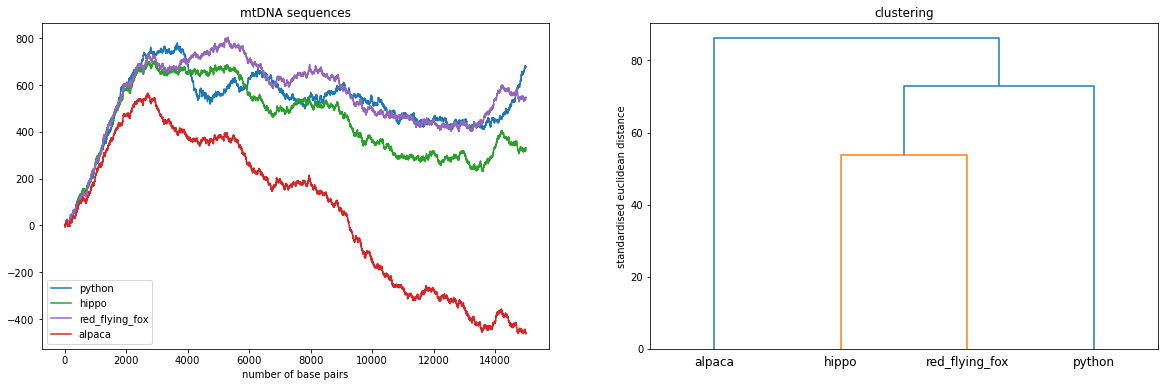

In [9]:
fig, ax = plt.subplots(ncols=2)

# sequences in Fig 9 left
truncate = 15000
for k, v in data.items():
    ax[0].plot(v[:truncate], label=k, color=colors[k])
ax[0].legend()
ax[0].set_xlabel('number of base pairs')
ax[0].set_title('mtDNA sequences')

# clustering in Fig 9 left
truncate = 16000
dp = np.zeros(int(comb(4, 2)))
for i, a_c in enumerate(combinations(data.keys(), 2)):
    dp[i] = stumpy.core.mass(data[a_c[0]][:truncate], data[a_c[1]][:truncate])
Z = linkage(dp, optimal_ordering=True)
dendrogram(Z, labels=[k for k in data.keys()], ax=ax[1])
ax[1].set_ylabel('standardised euclidean distance')
ax[1].set_title('clustering')
plt.show()

The clustering is clearly wrong. Amongst other problems, the alpaca (a mammal) is not most closely related to the python (a reptile).

### Consensus motif search
In order to obtain the correct relationships, we need to compare the motif that is most conserved across the mtDNA sequences. Let's take a window of 1000 base pairs.

In [10]:
m = 1000
rad, tsidx, ssidx = stumpy.ostinato(list(data.values()), m)
print(f'Found best radius {np.round(rad, 2)} in time series {tsidx} starting at index location {ssidx}.')

Found best radius 2.73 in time series 1 starting at index location 602.


Get the consensus motifs and perform clustering on them.

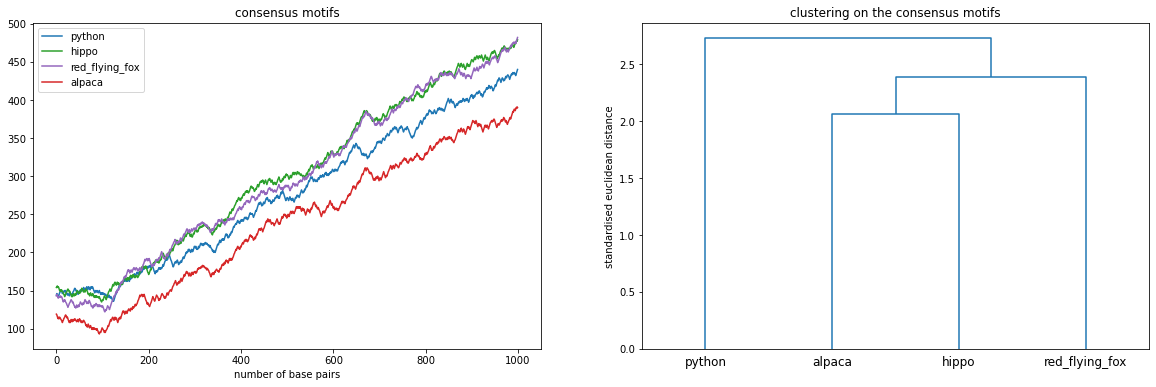

In [11]:
consensus_motifs = {}
best_motif = list(data.items())[tsidx][1][ssidx:ssidx+m]
for i, (k, v) in enumerate(data.items()):
    if i == tsidx:
        consensus_motifs[k] = best_motif
    else:
        ind = np.argmin(stumpy.core.mass(best_motif, v))
        consensus_motifs[k] = v[ind:ind+m]

        
fig, ax = plt.subplots(ncols=2)
# plot the consensus motifs
for animal, motif in consensus_motifs.items():
    ax[0].plot(motif, label=animal, color=colors[animal])
ax[0].legend()
# cluster consensus motifs
dp = np.zeros(int(comb(4, 2)))
for i, motif in enumerate(combinations(list(consensus_motifs.values()), 2)):
    dp[i] = stumpy.core.mass(motif[0], motif[1])
Z = linkage(dp, optimal_ordering=True)
dendrogram(Z, labels=[k for k in consensus_motifs.keys()])

ax[0].set_title('consensus motifs')
ax[0].set_xlabel('number of base pairs')
ax[1].set_title('clustering on the consensus motifs')
ax[1].set_ylabel('standardised euclidean distance')
plt.show()

Now this looks much better! The python is far away from the others. Amongst the mammalia the red flying fox (a bat) is less related to both the alpaca and the hippo which are the closest evolutionary relatives in this set of animals.